# <center> Обучение с учителем. Классификация
## <center> Предсказываем категорию дохода человека
<img src=https://blondeblog.ru/wp-content/uploads/2018/09/2.jpg.jpg>

### Пстроим классификатор, который позволит своевременно определять уходящих клиентов банка.

Для начала импортируем библиотеки, которые нам понадобятся:

In [27]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [4]:
churn_data = pd.read_csv('data/churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


RowNumber — номер строки таблицы;

CustomerId — идентификатор клиента;

Surname — фамилия клиента;

CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);

Geography — страна проживания клиента (банк межнациональный);

Gender — пол клиента;

Age — возраст клиента;

Tenure — сколько лет клиент пользуется банком;

Balance — сколько у клиента денег на счетах в банке;

NumOfProduct — число услуг банка, которые приобрёл клиент;

HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);

IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);

EstimatedSalary — предполагаемая заработная плата клиента;

Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

In [5]:
#Будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [6]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [7]:
#Проверим, что в наших данных нет пропусков:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;

TenureByAge — отношение времени пользования банком к возрасту клиента;

CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.


In [8]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [9]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [10]:
#Разделим набор данных на матрицу наблюдений X и столбец ответов y:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [11]:
#позаботимся о масштабах признаков. Проведём нормализацию матрицы наблюдений X
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

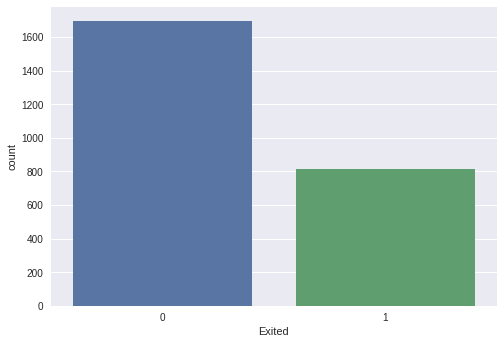

In [12]:
#посмотрим на сбалансированность данных
sns.countplot(data=churn_data, x='Exited');

In [13]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что наши классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %.
параметр 'stratify' помжет сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [15]:
#Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:
print('Train :', y_train.value_counts(normalize=True))
print()
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64

Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


   наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра, а для клиентов, у которых вероятность оттока наиболее высока, — специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому ложные срабатывания желательно минимизировать. Однако в то же время необходимо сохранить как можно больше клиентов.
   
В данной задаче нам нужен баланс между precision и recall, поэтому мы будем использовать -меру.

In [16]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='sag')

In [17]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print()
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881


              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.63      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.69      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628



Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

In [18]:
X_train_poly = X_train.copy()
X_test_poly = X_test.copy()
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3, include_bias=False)

X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly = poly.fit_transform(X_test_poly)

In [19]:
#Посмотрим сколько признаков сформировалось
X_train_poly.shape[1]

454

Обучите модель логистической регрессии на полиномиальных признаках

In [20]:
#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [21]:
#Делаем предсказание для тренировочной выборки
y_train_pred_poly = log_reg_poly.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(f'Предсказания на обучающей выборке с полиномиальными признаками: ')
print(metrics.classification_report(y_train, y_train_pred_poly))
print()
print(f'Предсказания на тестовой выборке: ')
#Делаем предсказание для тестовой выборки
y_test_pred_poly = log_reg_poly.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_poly))

Предсказания на обучающей выборке с полиномиальными признаками: 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.78      0.56      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881


Предсказания на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628



Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.

In [22]:
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

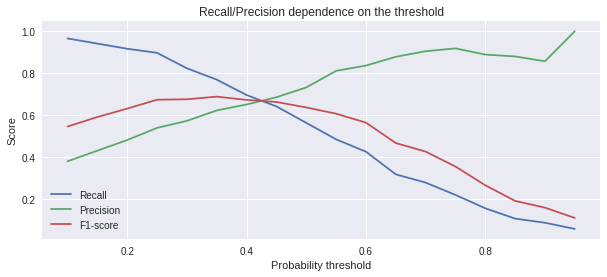

In [23]:
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [24]:
f1_from_THRESHOLDS = pd.DataFrame({'f1_scores':f1_scores, 'threshold':thresholds})
f1_from_THRESHOLDS.iloc[5,:]


f1_scores    0.688596
threshold    0.350000
Name: 5, dtype: float64

In [25]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628



# Дерево решений

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [29]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=10,
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.70
Test: 0.65


# Случайный лес

In [31]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    min_samples_leaf=10,
    max_depth=6,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.71
Test: 0.66


# Бустинг

In [33]:
#Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=500,
    min_samples_leaf=10,
    max_depth=4,
    random_state=42
)
#Обучаем модель
gb.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = gb.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = gb.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.77
Test: 0.70


# Стекинг

In [34]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=10,
        max_depth=6,
        random_state=42
        )
    ),
    ('rf', ensemble.RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        min_samples_leaf=5,
        max_depth=10,
        random_state=42
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.01,
        n_estimators=500,
        min_samples_leaf=10,
        max_depth=4,
        random_state=42
        )
    )
]

#Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
#Обучаем модель
stack.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = stack.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = stack.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.78
Test: 0.67


Выберем оптимальный порог вероятности для наилучшей модели

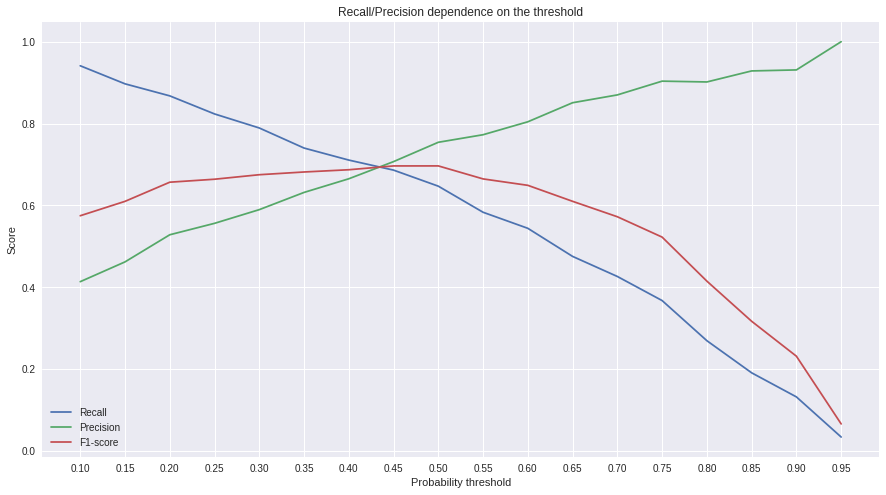

In [36]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = gb.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(15, 8)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [43]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.5
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       424
           1       0.75      0.65      0.70       204

    accuracy                           0.82       628
   macro avg       0.80      0.77      0.78       628
weighted avg       0.81      0.82      0.81       628

